In [1]:
import pandas as pd
import numpy as np
from tcrdist.repertoire import TCRrep
from scipy.sparse import csr_matrix
import matplotlib.colors as mcolors
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import umap
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

#### **数据读取**

In [208]:
data = pd.read_csv('vdjdb.txt', sep = '\t')

In [209]:
score = data[data['vdjdb.score'].isin([1, 2, 3])]

In [210]:
score[(score['gene'] == 'TRA') & (score['species'] == 'HomoSapiens')]

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2,sort,sanger,no,no
5,3,TRA,CAVKASGSRLT,TRAV2*01,NaN,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVKASGSRLT"", ""cdr3_old"": ""CAVKASGSR...",2,sort,sanger,yes,yes
7,4,TRA,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAYRPPGTYKYIF"", ""cdr3_old"": ""CAYRPPG...",2,sort,sanger,no,no
9,5,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEQGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92681,30550,TRA,CIALNARLMF,TRAV26-1*01,TRAJ31*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQPELPYPQPQL,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIALNARLMF"", ""cdr3_old"": ""CIALNARLMF...",2,sort,singlecell,no,no
92683,30551,TRA,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,FPQPEQPFPWQP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAMREGRYSSASKIIF"", ""cdr3_old"": ""CAMR...",2,sort,singlecell,no,no
92685,30552,TRA,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,FPQPEQPFPWQP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CLVGDGDGGATNKLIF"", ""cdr3_old"": ""CLVG...",2,sort,singlecell,no,no
92689,30554,TRA,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,QLQPFPQPELPY,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAASVLYGSSNTGKLIF"", ""cdr3_old"": ""CAA...",2,sort,singlecell,no,no


#### **数据准备**

In [211]:
data = data.drop(['web.method', 'web.method.seq', 'web.cdr3fix.nc','web.cdr3fix.unmp','reference.id', 'method', 'meta', 'cdr3fix'], axis=1)
data = data.drop(['mhc.a', 'mhc.b', 'mhc.class', 'antigen.gene'], axis = 1)

In [6]:
data_clean = data.dropna()

#### **Alpha链**

In [7]:
data_alpha = data_clean[(data_clean['gene'] == 'TRA') & (data_clean['complex.id'] == 0)]

##### **Distance(Human)**

In [8]:
# data_alpha_human = data_alpha[data_alpha['species'] == 'HomoSapiens']

In [9]:
# 抽样
# data_alpha_human_sampled = conditional_sample(data_alpha_human, percentage=0.3)

In [10]:
data_alpha_human_sampled = score[(score['gene'] == 'TRA') & (score['species'] == 'HomoSapiens') & (score['complex.id'] == 0)]

In [11]:
data_alpha_human_sampled.shape

(871, 21)

改名

In [12]:
data_alpha_human_sampled = data_alpha_human_sampled.rename(columns = {'gene':'gene_a',
                                           'cdr3':'cdr3_a_aa',
                                           'v.segm':'v_a_gene',
                                           'j.segm':'j_a_gene'})

In [13]:
tr_human_alpha = TCRrep(cell_df = data_alpha_human_sampled, 
            organism = 'human', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000001BF54019A80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.32 of 871 were not ca

In [14]:
tr_human_alpha.pw_alpha

array([[  0, 162, 163, ..., 126, 126, 144],
       [162,   0,  92, ..., 101, 101, 110],
       [163,  92,   0, ...,  86,  86,  89],
       ...,
       [126, 101,  86, ...,   0,   0,  42],
       [126, 101,  86, ...,   0,   0,  42],
       [144, 110,  89, ...,  42,  42,   0]], dtype=int16)

In [15]:
tr_human_alpha.pw_alpha.shape

(835, 835)

##### **Distance(Mouse)**

In [16]:
data_alpha_mouse = data_alpha[data_alpha['species'] == 'MusMusculus']

改名

In [17]:
data_alpha_mouse = data_alpha_mouse.rename(columns = {'gene':'gene_a',
                                           'cdr3':'cdr3_a_aa',
                                           'v.segm':'v_a_gene',
                                           'j.segm':'j_a_gene'})

In [18]:
tr = TCRrep(cell_df = data_alpha_mouse, 
            organism = 'mouse', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000001BF54019A80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


In [19]:
tr.pw_alpha

array([[  0,  90,  90, ..., 117, 131, 137],
       [ 90,   0,  24, ..., 132, 113, 119],
       [ 90,  24,   0, ..., 144, 119, 125],
       ...,
       [117, 132, 144, ...,   0, 131, 125],
       [131, 113, 119, ..., 131,   0,   6],
       [137, 119, 125, ..., 125,   6,   0]], dtype=int16)

#### **Beta链**

In [20]:
data_beta = data_clean[data_clean['gene'] == 'TRB']

##### **Distance(Human)**

In [21]:
data_beta_human = data_beta[data_beta['species'] == 'HomoSapiens']

改名

In [22]:
data_beta_human_sampled = data_beta_human_sampled.rename(columns = {'gene':'gene_b',
                                           'cdr3':'cdr3_b_aa',
                                           'v.segm':'v_b_gene',
                                           'j.segm':'j_b_gene'})

NameError: name 'data_beta_human_sampled' is not defined

In [ ]:
tr_human_beta = TCRrep(cell_df = data_beta_human_sampled, 
            organism = 'human', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

In [ ]:
tr_human_beta.pw_beta

##### **Distance(Mouse)**

In [ ]:
data_beta_mouse = data_beta[data_beta['species'] == 'MusMusculus']

In [ ]:
data_beta_mouse = data_beta_mouse.rename(columns = {'gene':'gene_b',
                                           'cdr3':'cdr3_b_aa',
                                           'v.segm':'v_b_gene',
                                           'j.segm':'j_b_gene'})

In [ ]:
data_beta_mouse.reset_index(drop=True, inplace=True)
data_beta_mouse.head()

In [ ]:
tr_mouse_beta = TCRrep(cell_df = data_beta_mouse, 
            organism = 'mouse', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

In [ ]:
tr_mouse_beta.pw_beta

# 4-5问(Alpha)


In [23]:
alpha_distance = tr_human_alpha.pw_alpha

In [24]:
clone_df = tr_human_alpha.clone_df

### 降维

先进性mds对数据进行降维，再把mds的结果作为tsne的初始化参数的输入

In [26]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=5)
positions = mds.fit_transform(alpha_distance)

tsne_reducer = TSNE(n_components=2, random_state=42, metric='precomputed', init=positions, perplexity=100, learning_rate=1000)
tsne_results = tsne_reducer.fit_transform(alpha_distance)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


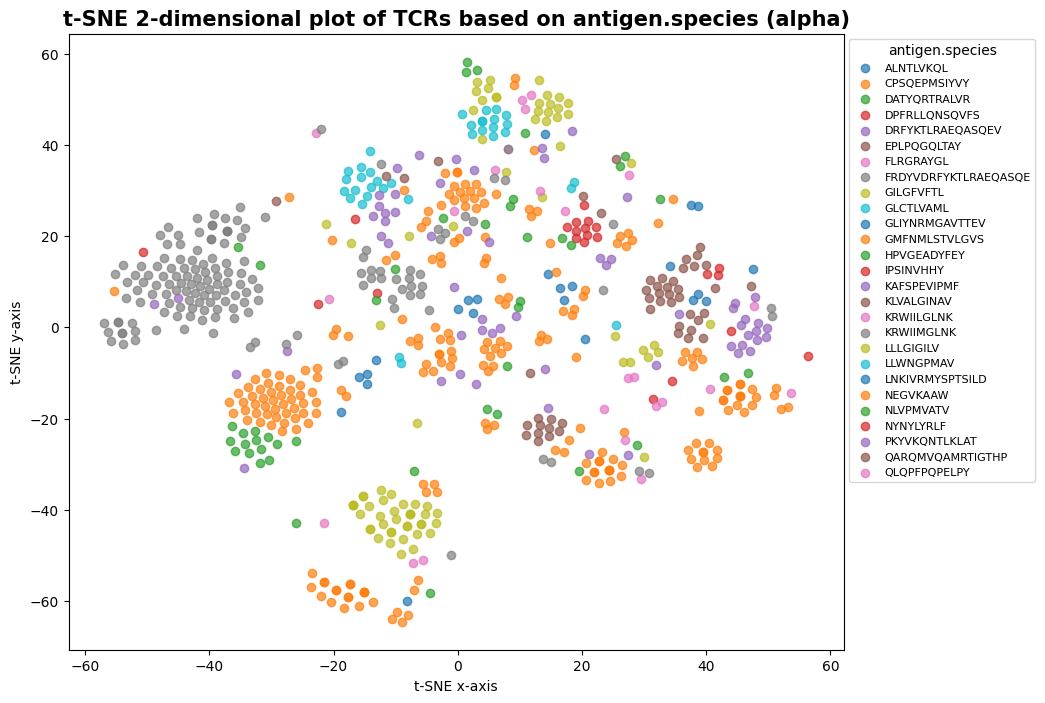

In [61]:
specificity = clone_df['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2"  # 根据 unique_antigen_species 的数量增减颜色
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(tsne_results[true_indiex, 0], tsne_results[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('t-SNE 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel('t-SNE x-axis')
plt.ylabel('t-SNE y-axis')
plt.legend(title='antigen.species', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha.png')
plt.show()

# **聚类**

In [28]:
# stresses_2 = []
# K = 25
# for k in range(1, K+1):
#     mds = MDS(n_components=k, dissimilarity="precomputed", metric=False, normalized_stress=True, random_state=42)
#     mds.fit(alpha_distance)
#     stresses_2.append(mds.stress_)

# plt.figure()
# plt.plot(range(1, K+1), stresses, 'bx-')
# plt.xlabel('k')
# plt.ylabel('stresses')
# plt.title('Scree plot')

In [29]:
# K = 25

# plt.figure()
# plt.plot(range(1, K+1), stresses_2, 'bx-')
# plt.xlabel('k')
# plt.ylabel('stresses')
# plt.title('Scree plot')

In [30]:
mds = MDS(n_components=8, dissimilarity="precomputed", metric=True, random_state=42)
cluster_positions = mds.fit_transform(alpha_distance)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


以gaussian mixture来进行聚类分析

In [32]:
clone_df_features = clone_df[['antigen.species']]
dis = pd.DataFrame(cluster_positions)
con = pd.concat([clone_df_features, dis], axis=1)
con = con[con['antigen.species'].isin(['CMV', 'EBV', 'HCV', 'HIV-1', 'HomoSapiens', 'InfluenzaA', 'SARS-CoV-2', 'YFV'])]

In [33]:
gaussian_init = con.groupby('antigen.species').mean()
gaussian_init

,0,1,2,3,4,5,6,7
antigen.species,,,,,,,,
CMV,-4.477822,9.230522,-2.150196,-2.970437,0.937415,8.164398,13.309713,15.276942
EBV,-3.736922,12.994361,8.591128,-6.124524,1.813788,-4.409996,-2.158151,8.547256
HCV,-5.491812,-5.594233,-36.085380,-10.650367,-27.313543,-23.218147,-1.653135,-25.954857
HIV-1,-5.616752,-1.414138,17.311868,5.544367,14.999113,-7.393774,-2.765766,-22.157182
HomoSapiens,18.794818,23.216449,-7.653082,-9.945587,-32.165126,-0.921650,-6.436389,-30.119835
InfluenzaA,-2.222020,-15.320479,-10.299035,-1.552119,-7.335968,4.467658,-9.255497,7.470921
SARS-CoV-2,23.344021,-2.048163,-15.008927,7.520157,-5.742777,-7.140617,-11.161044,8.277310
YFV,34.395175,1.812779,1.570990,-9.506772,-45.775477,-1.340264,2.975335,-40.378955


确定一下输入的高斯分布中均值

In [430]:
gmm = GaussianMixture(n_components=8, max_iter=300, means_init=gaussian_init, random_state=42)

gmm.fit(cluster_positions)

GaussianMixture(max_iter=300,
                means_init=array([[ -4.47782198,   9.23052241,  -2.15019644,  -2.97043657,
          0.93741523,   8.16439807,  13.30971335,  15.2769418 ],
       [ -3.73692188,  12.99436057,   8.59112815,  -6.12452388,
          1.81378773,  -4.40999559,  -2.15815092,   8.54725619],
       [ -5.49181238,  -5.59423276, -36.08537979, -10.65036724,
        -27.31354341, -23.21814716,  -1.65313528, -25.95485666],
       [ -5.6167518...
        -32.16512601,  -0.92164966,  -6.43638868, -30.11983527],
       [ -2.22201969, -15.32047924, -10.29903499,  -1.55211922,
         -7.33596761,   4.46765835,  -9.25549692,   7.47092081],
       [ 23.34402056,  -2.04816322, -15.0089271 ,   7.52015672,
         -5.74277711,  -7.14061665, -11.16104376,   8.27731003],
       [ 34.39517539,   1.81277912,   1.57099049,  -9.50677194,
        -45.77547739,  -1.3402644 ,   2.97533525, -40.37895463]]),
                n_components=8, random_state=42)

In [35]:
labels = gmm.predict(cluster_positions)

In [36]:
clone_df['label'] = labels

In [37]:
clone_df.groupby(['label', 'antigen.species']).count().to_csv('clone_df3.csv')

In [38]:
cluster_results = np.column_stack((cluster_positions, labels))

In [40]:
label = 0
bool = np.isin(cluster_results[:, -1], label)

cluster_0_coordinate = cluster_results[bool][:, 0:-1]

clone_df_0 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


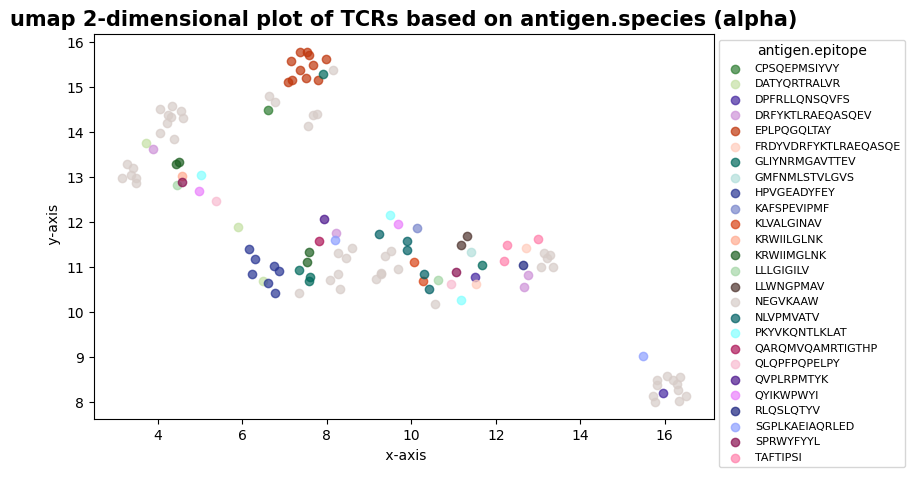

In [41]:
reducer_umap = umap.UMAP(n_neighbors=30, min_dist=0.25, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_0_coordinate)


specificity = clone_df_0['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_0')
plt.show()

In [42]:
label = 1
bool = np.isin(cluster_results[:, -1], label)

cluster_1_coordinate = cluster_results[bool][:, 0:-1]

clone_df_1 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


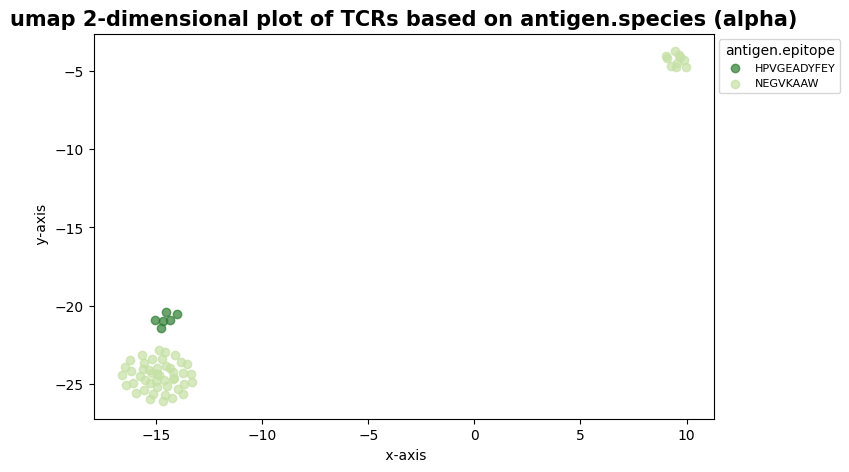

In [43]:
reducer_umap = umap.UMAP(n_neighbors=50, min_dist=0.25, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_1_coordinate)


specificity = clone_df_1['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_1')
plt.show()

In [44]:
label = 2
bool = np.isin(cluster_results[:, -1], label)

cluster_2_coordinate = cluster_results[bool][:, 0:-1]

clone_df_2 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


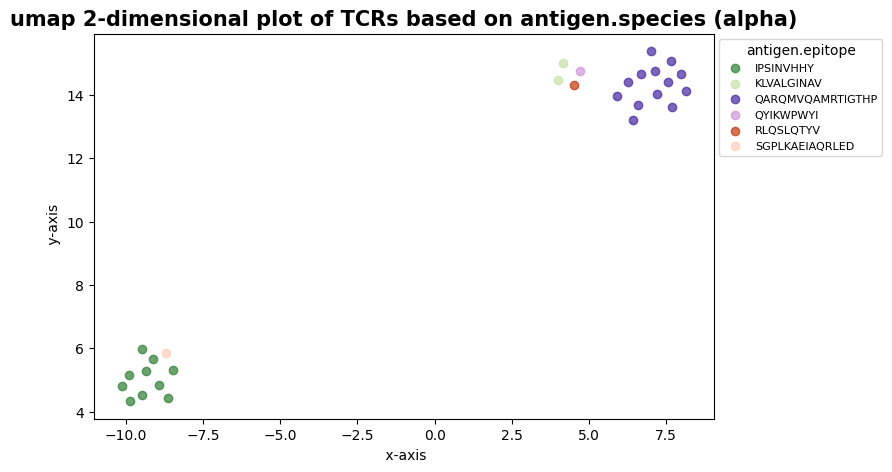

In [45]:
reducer_umap = umap.UMAP(n_neighbors=20, min_dist=0.25, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_2_coordinate)


specificity = clone_df_2['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_2')
plt.show()

In [46]:
label = 3
bool = np.isin(cluster_results[:, -1], label)

cluster_3_coordinate = cluster_results[bool][:, 0:-1]

clone_df_3 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


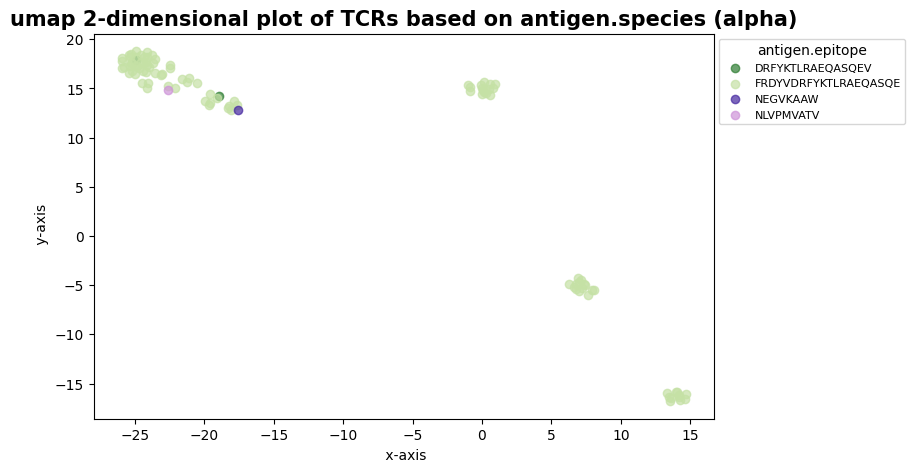

In [47]:
reducer_umap = umap.UMAP(n_neighbors=30, min_dist=0.5, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_3_coordinate)


specificity = clone_df_3['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_3')
plt.show()

In [48]:
label = 4
bool = np.isin(cluster_results[:, -1], label)

cluster_4_coordinate = cluster_results[bool][:, 0:-1]

clone_df_4 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


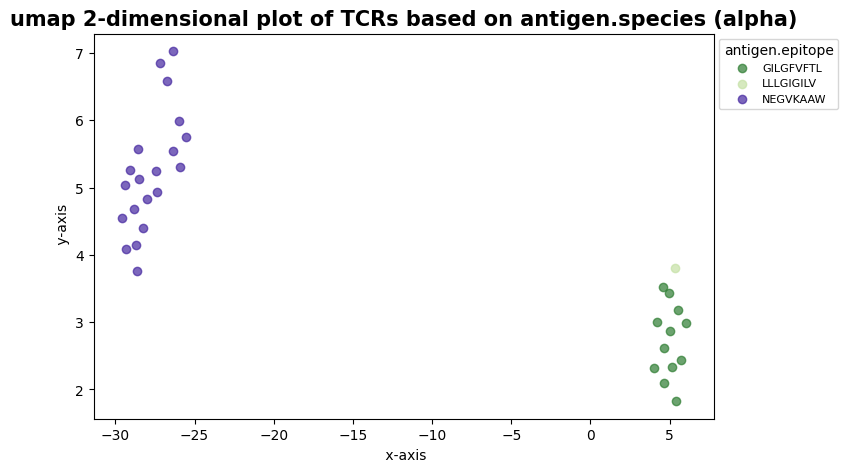

In [49]:
reducer_umap = umap.UMAP(n_neighbors=20, min_dist=0.3, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_4_coordinate)


specificity = clone_df_4['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_4')
plt.show()

In [50]:
label = 5
bool = np.isin(cluster_results[:, -1], label)

cluster_5_coordinate = cluster_results[bool][:, 0:-1]

clone_df_5 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


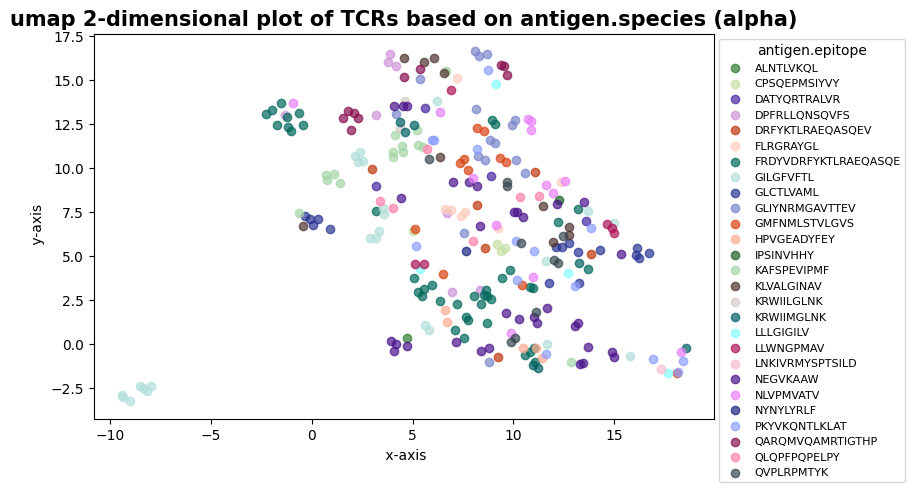

In [51]:
reducer_umap = umap.UMAP(n_neighbors=5, min_dist=0.9, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_5_coordinate)


specificity = clone_df_5['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_5')
plt.show()

In [52]:
label = 6
bool = np.isin(cluster_results[:, -1], label)

cluster_6_coordinate = cluster_results[bool][:, 0:-1]

clone_df_6 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


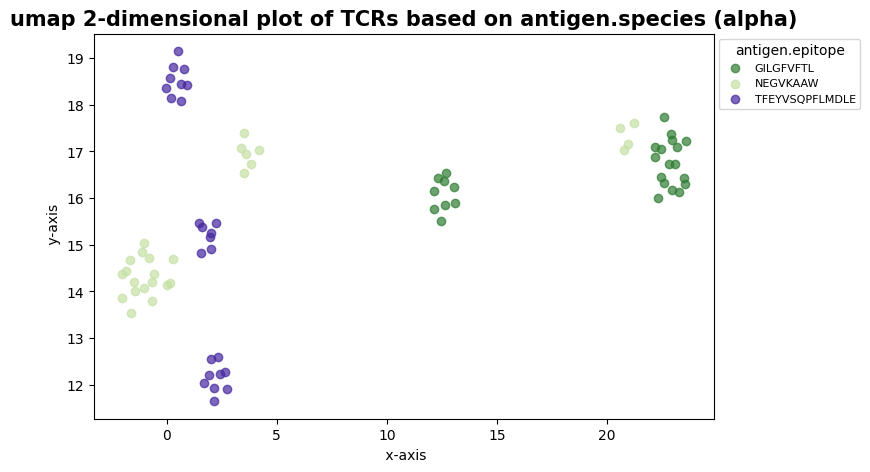

In [53]:
reducer_umap = umap.UMAP(n_neighbors=60, min_dist=0.4, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_6_coordinate)


specificity = clone_df_6['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_6')
plt.show()

In [54]:
label = 7
bool = np.isin(cluster_results[:, -1], label)

cluster_7_coordinate = cluster_results[bool][:, 0:-1]

clone_df_7 = clone_df[clone_df['label'] == label]

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


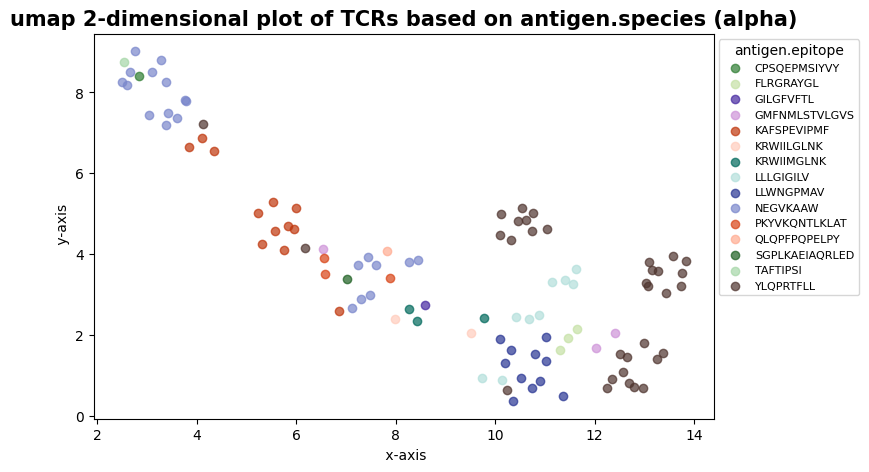

In [55]:
reducer_umap = umap.UMAP(n_neighbors=40, min_dist=0.4, random_state=42)
embedding0 = reducer_umap.fit_transform(cluster_7_coordinate)


specificity = clone_df_7['antigen.epitope']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(8, 5))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(embedding0[true_indiex, 0], embedding0[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('umap 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel(' x-axis')
plt.ylabel(' y-axis')
plt.legend(title='antigen.epitope', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha_7')
plt.show()

# **分类**

In [484]:
def to_dataframe(position, label, clone_df):
    distance = pd.DataFrame(position)
    distance['label'] = label
    distance['antigen.epitope'] = clone_df['antigen.epitope']
    return distance

# 数据平衡性
def balance(data, label):
    '''
    data balance
    '''
    data_counts = data[label].value_counts()
    max_class_count = data_counts.max()
    oversampled_data = pd.DataFrame()
    
    # oversample
    oversampled_data = pd.DataFrame()
    for class_index in data_counts.index:
        class_samples = data[data[label] == class_index]
        oversampled_samples = resample(class_samples, replace=True, n_samples=max_class_count, random_state=42)
        oversampled_data = pd.concat([oversampled_data, oversampled_samples])

    return oversampled_data

def train_first_classifier(data):
    # 提取同标签下的所有距离
    position = data.iloc[:, 0:-2].values
    labels = data['label']
    
    classifier = GaussianMixture(n_components=8, max_iter=300, means_init=gaussian_init, random_state=42)
    classifier.fit(position)
    
    return classifier


def train_subclassifier(data, label):
    '''
    label是已经进行过分类的每个坐标的标签
    '''
    # 平衡数据
    origin_data = data[data['label'] == label]
    balanced_data = balance(data=origin_data, label='antigen.epitope')

    # 提取同标签下的所有距离
    bool = np.isin(balanced_data['label'], label)
    distance = balanced_data.iloc[:, 0:-2].values
    distance_coordinate = distance[bool]
    
    # 再提取每个label下的antigen.eptitope
    specificity = balanced_data[balanced_data['label'] == label]['antigen.epitope']
        
    classifier = KNeighborsClassifier(n_neighbors=30)
    classifier.fit(distance_coordinate, specificity)

    return classifier

def get_validate_data(sample_num, chain, species, data=data):
    test_data = data[data['vdjdb.score'] == 0]
    test_alpha_sample = test_data[(test_data['gene'] == 'TRA') &  (test_data['species'] == 'HomoSapiens') &(test_data['complex.id'] == 0)]
    test_alpha_sample = test_alpha_sample.sample(n=sample_num)
    test_alpha_sample = test_alpha_sample.rename(columns = {'gene':'gene_a',
                                           'cdr3':'cdr3_a_aa',
                                           'v.segm':'v_a_gene',
                                           'j.segm':'j_a_gene'})

    tr = TCRrep(cell_df = test_alpha_sample,              
            organism = 'human', 
            chains = ['alpha'], 
            compute_distances = True)

    tr.compute_rect_distances(df = tr.clone_df, df2 = tr_human_alpha.clone_df)

    return tr

def distance_to_feature(distance):
    model = torch.load('to_feature.pth')
    model.eval()
    input_data = distance
    input_tensor = torch.from_numpy(input_data).float()
    
    with torch.no_grad():
        output = model(input_tensor)
        
    return output

In [485]:
train_data = to_dataframe(position=cluster_positions, label=labels, clone_df=clone_df)
first_classifier = train_first_classifier(data=train_data)

# 训练子分类器
sub_classifiers = []
label_num = len(np.unique(train_data['label']))

for i in range(label_num):
    classifier = train_subclassifier(data=train_data, label=i)
    sub_classifiers.append(classifier)

In [514]:
new_test['antigen.epitope'][0]

'NLVPMVATV'

In [516]:
acc_1 = []

for i in range(len(new_test)):
    all_tag = clone_df[clone_df['label'] == new_test['label'][i]]
    speci = np.unique(all_tag['antigen.epitope'])
    acc_1.append(new_test['antigen.epitope'][i] in speci)

sum(acc_1)/len(acc_1)

0.9081632653061225

In [486]:
test = get_validate_data(sample_num=200, chain='TRA', species='HomoSapians')
position_test = distance_to_feature(distance=test.rw_alpha)
tag = first_classifier.predict(position_test)
new_test = to_dataframe(position=position_test, label=tag, clone_df=test.clone_df)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000001BF54019A80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.8 of 200 were not cap

In [496]:
test.clone_df

,complex.id,gene_a,cdr3_a_aa,v_a_gene,j_a_gene,species,antigen.epitope,antigen.species,vdjdb.score,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,count,clone_id
0,0,TRA,CAACQGGSEKLVF,TRAV41*01,TRAJ57*01,HomoSapiens,NLVPMVATV,CMV,0,VGI.......SA,LSS.....GK,NIQEKH,1,1
1,0,TRA,CAANGDSWGKLQF,TRAV25*01,TRAJ24*01,HomoSapiens,NLVPMVATV,CMV,0,TTL.......SN,LVKS...GEV,GEAKKN,1,2
2,0,TRA,CAAPDQTGANNLFF,TRAV21*01,TRAJ36*01,HomoSapiens,GILGFVFTL,InfluenzaA,0,DSA......IYN,IQSS...QRE,DKSSGR,1,3
3,0,TRA,CAAPGADSNYQLIW,TRAV1-2*01,TRAJ33*01,HomoSapiens,NLVPMVATV,CMV,0,TSG......FNG,NVL....DGL,SRSKGY,1,4
4,0,TRA,CAAPGENNARLMF,TRAV8-3*01,TRAJ31*01,HomoSapiens,GILGFVFTL,InfluenzaA,0,YGA......TPY,YFSG..DTLV,KRSQSS,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0,TRA,CVVNSPEGNTPLVF,TRAV12-1*01,TRAJ29*01,HomoSapiens,YLQPRTFLL,SARS-CoV-2,0,NSA......SQS,VYS....SGN,NRASQY,1,94
94,0,TRA,CVVNTPGYSTLTF,TRAV12-1*01,TRAJ11*01,HomoSapiens,YLQPRTFLL,SARS-CoV-2,0,NSA......SQS,VYS....SGN,NRASQY,1,95
95,0,TRA,CVVSVNDRGSTLGRLYF,TRAV10*01,TRAJ18*01,HomoSapiens,GILGFVFTL,InfluenzaA,0,VSP......FSN,MTFS...ENT,DADTKQ,1,96
96,0,TRA,CVVTRGAYNTDKLIF,TRAV12-1*01,TRAJ34*01,HomoSapiens,NLVPMVATV,CMV,0,NSA......SQS,VYS....SGN,NRASQY,1,97


In [517]:
acc = []
acc_1 = []

for i in range(len(new_test)):
    all_tag = clone_df[clone_df['label'] == new_test['label'][i]]
    speci = np.unique(all_tag['antigen.epitope'])
    acc_1.append(new_test['antigen.epitope'][i] in speci)
for i in range(10):
    test = get_validate_data(sample_num=100, chain='TRA', species='HomoSapians')
    position_test = distance_to_feature(distance=test.rw_alpha)
    tag = first_classifier.predict(position_test)
    new_test = to_dataframe(position=position_test, label=tag, clone_df=test.clone_df)
    
    label_test = new_test['label']
    predictions = []
    data_specificity = []
        
    for i in np.unique(label_test):
        data_label = new_test[new_test['label'] == i].iloc[:, :-2]
        label_specificity = new_test[new_test['label'] == i]['antigen.epitope']
        prediction = sub_classifiers[i].predict(data_label)
        predictions.append(prediction)
        data_specificity.append(label_specificity)
        
    correct = 0
    num = 0
        
    for i in range(len(predictions)):
        correct += sum(predictions[i] == data_specificity[i])
        num += len(predictions[i])

    acc.append(correct/num)

    for i in range(len(new_test)):
        all_tag = clone_df[clone_df['label'] == new_test['label'][i]]
        speci = np.unique(all_tag['antigen.epitope'])
        acc_1.append(new_test['antigen.epitope'][i] in speci)

print('first classification accuracy:', np.mean(acc_1))
print('overall accuracy:', np.mean(acc))

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000001BF54019A80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.2 of 100 were not cap

first classification accuracy: 0.9186155285313377
overall accuracy: 0.0868390419437652


C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000001BF54019A80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


# 用神经网络把距离矩阵投射到特征空间

In [370]:
# class EnhancedNN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(EnhancedNN, self).__init__()
#         self.layer1 = nn.Linear(input_dim, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.3)  # Slightly higher dropout

#         self.layer2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.relu2 = nn.ReLU()

#         self.layer3 = nn.Linear(128, 128)
#         self.bn3 = nn.BatchNorm1d(128)
#         self.relu3 = nn.ReLU()
#         self.dropout2 = nn.Dropout(0.3)

#         self.layer4 = nn.Linear(128, 64)
#         self.bn4 = nn.BatchNorm1d(64)
#         self.relu4 = nn.ReLU()

#         self.layer5 = nn.Linear(64, 64)
#         self.bn5 = nn.BatchNorm1d(64)
#         self.relu5 = nn.ReLU()
#         self.dropout3 = nn.Dropout(0.3)

#         self.layer6 = nn.Linear(64, 32)
#         self.bn6 = nn.BatchNorm1d(32)
#         self.relu6 = nn.ReLU()

#         self.layer7 = nn.Linear(32, output_dim)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)

#         x = self.layer2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)

#         x = self.layer3(x)
#         x = self.bn3(x)
#         x = self.relu3(x)
#         x = self.dropout2(x)

#         x = self.layer4(x)
#         x = self.bn4(x)
#         x = self.relu4(x)

#         x = self.layer5(x)
#         x = self.bn5(x)
#         x = self.relu5(x)
#         x = self.dropout3(x)

#         x = self.layer6(x)
#         x = self.bn6(x)
#         x = self.relu6(x)

#         x = self.layer7(x)
#         return x

# class MyDataset(Dataset):
#     def __init__(self, high_dim_data, low_dim_data):
#         """
#         初始化数据集
#         :param high_dim_data: 高维数据，一个NumPy数组或者PyTorch张量
#         :param low_dim_data: 低维数据（通过MDS降维后的结果），一个NumPy数组或者PyTorch张量
#         """
#         self.high_dim_data = torch.tensor(high_dim_data, dtype=torch.float32)
#         self.low_dim_data = torch.tensor(low_dim_data, dtype=torch.float32)
    
#     def __len__(self):
#         """
#         返回数据集中的样本数
#         """
#         return len(self.high_dim_data)
    
#     def __getitem__(self, idx):
#         """
#         根据索引idx返回一对数据（高维输入和对应的低维输出）
#         """
#         return self.high_dim_data[idx], self.low_dim_data[idx]

In [389]:
# Xtr, Xtest, Ytr, Ytest = train_test_split(alpha_distance, cluster_positions, test_size = 0.2, random_state = 10)
# high_dim_data = Xtr
# low_dim_data = Ytr
# val_inputs_tensors = torch.from_numpy(Xtest).float()
# val_targets_tensors = torch.from_numpy(Ytest).float()

# dataset = MyDataset(high_dim_data, low_dim_data)
# dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

# val_dataset = TensorDataset(val_inputs_tensors, val_targets_tensors)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# input_dim = 835
# output_dim = 8

# # 初始化模型
# model = EnhancedNN(input_dim, output_dim)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

# # 设置TensorBoard
# writer = SummaryWriter()

# num_epochs = 300
# for epoch in range(num_epochs):
#     model.train()
#     for inputs, targets in dataloader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     # 验证阶段
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for val_inputs, val_targets in val_dataloader:
#             val_outputs = model(val_inputs)
#             val_loss += criterion(val_outputs, val_targets).item()
#     val_loss /= len(val_dataloader)

#     # 调整学习率
#     scheduler.step(val_loss)

#     # 记录到TensorBoard
#     writer.add_scalar('Training Loss', loss.item(), epoch)
#     writer.add_scalar('Validation Loss', val_loss, epoch)

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')